In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

import sys
sys.path.insert(0, '../Modules/')
sys.path.insert(0, '../Shared code/')
/
import pose_estimation as pe  # noqa (ignore PEP 8 style)
from gait_metrics import gait_dataframe  # noqa
from peakdet import peakdet  # noqa
from general import mad_outliers

# %% Read DataFrame

directory = '../../../MEGA/Data/Kinect Zeno/Kinect processed'
file_name = '2014-12-22_P007_Pre_004.pkl'

load_path = os.path.join(directory, file_name)
df = pd.read_pickle(load_path)


# %% Parameters

lower_part_types = ['HEAD', 'HIP', 'UPPER_LEG', 'KNEE', 'LOWER_LEG', 'FOOT']


lengths = [62.1080, 20.1733, 14.1756, 19.4509, 20.4996]

radii = [i for i in range(0, 30, 5)]

edges = np.matrix('0 1; 1 2; 2 3; 3 4; 4 5; 3 5; 1 3')


# %% Select positions

# Find the best positions for each image frame
best_pos_series = df.apply(lambda x: pe.process_frame(x.to_dict(),
                           lower_part_types, edges, lengths, radii), axis=1)

n_frames = len(df)
for f in range(n_frames):
    row = df.loc[f]

    pe.process_frame(row.to_dict(), lower_part_types, edges, lengths, radii)


# %% Extract head and foot positions

# Each row i is a tuple containing the best positions for frame i
# Split each tuple into columns of a DataFrame
df_best_pos = pd.DataFrame(best_pos_series.values.tolist(),
                           columns=['Side A', 'Side B'])

df_best_pos = df_best_pos.dropna()

# Extract the head and feet positions
head_pos = df_best_pos['Side A'].apply(lambda row: row[0, :])
L_foot_pos = df_best_pos['Side A'].apply(lambda row: row[-1, :])
R_foot_pos = df_best_pos['Side B'].apply(lambda row: row[-1, :])

# Combine into new DataFrame
df_head_feet = pd.concat([head_pos, L_foot_pos, R_foot_pos], axis=1)
df_head_feet.columns = ['HEAD', 'L_FOOT', 'R_FOOT']
df_head_feet.index.name = 'Frame'


# %% Remove outlier frames

y_foot_L = df_head_feet.apply(lambda row: row['L_FOOT'][1], axis=1).values
y_foot_R = df_head_feet.apply(lambda row: row['R_FOOT'][1], axis=1).values

y_foot_L_filtered = mad_outliers(y_foot_L, 2)
y_foot_R_filtered = mad_outliers(y_foot_R, 2)

good_frame_L = ~np.isnan(y_foot_L_filtered)
good_frame_R = ~np.isnan(y_foot_R_filtered)

df_head_feet = df_head_feet[good_frame_L & good_frame_R]


# %% Gait metrics


foot_dist = df_head_feet.apply(lambda row: np.linalg.norm(
                               row['L_FOOT'] - row['R_FOOT']), axis=1)


In [3]:
# Cluster frames with k means to locate the 4 walking passes

frames = foot_dist.index.values.reshape(-1, 1)
k_means = KMeans(n_clusters=4, random_state=0).fit(frames)

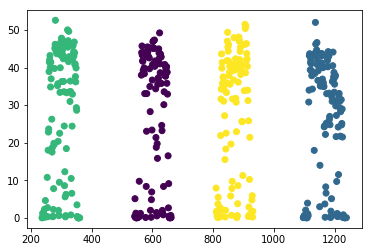

In [4]:
foot_dist_points = foot_dist.reset_index().values
frame_labels = k_means.labels_
plt.scatter(foot_dist_points[:, 0], foot_dist_points[:, 1], c=frame_labels)

In [5]:
from general import root_mean_square

# Extract upper foot distance values
rms = root_mean_square(foot_dist.values)

# Upper foot distance values of one walking pass
upper_of_pass = (frame_labels == 0) & (foot_dist > rms)

cluster_0 = foot_dist_points[upper_of_pass]

In [6]:
from clustering import mean_shift, gaussian_kernel_shift

# Take column without converting to 1d array
input_frames = cluster_0[:, 0, None]
labels, centroids, k = mean_shift(input_frames, gaussian_kernel_shift, radius=5)

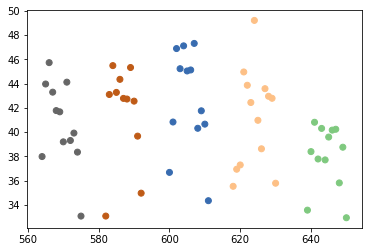

In [7]:
plt.scatter(cluster_0[:,0], cluster_0[:,1], c=labels, cmap='Accent')

In [8]:
from general import closest_point

# Find the frames closest to the mean shift centroids 
upper_pass_frames = frames[upper_of_pass]
centroid_frames = [closest_point(upper_pass_frames, x)[0].item() for x in centroids]    

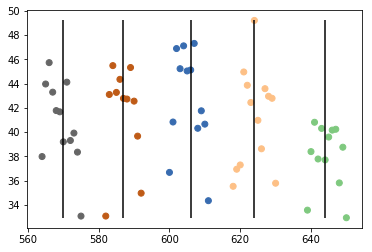

In [9]:
ax = plt.axes()
x, y = cluster_0.T
ax.scatter(x, y, c=labels, cmap='Accent')
ax.vlines(centroid_frames, y.min(), y.max())

In [10]:
# Extract upper foot distance values
rms = root_mean_square(foot_dist.values)

# Upper foot distance values of one walking pass
upper_of_pass = (frame_labels == 0) & (foot_dist > rms)

cluster_0 = foot_dist_points[upper_of_pass]

In [11]:
def foot_dist_peaks(foot_dist, frame_labels):

    frames = foot_dist.index.values.reshape(-1, 1)
    
    # Extract upper foot distance values
    rms = root_mean_square(foot_dist.values)

    unique_labels = np.unique(frame_labels)

    frame_list = []
    
    # Each label represent one walking pass by the camera
    for i in unique_labels:

        # Upper foot distance values of one walking pass
        upper_of_pass = (frame_labels == i) & (foot_dist > rms)

        # Find centres of foot distance peaks with mean shift
        input_frames = frames[upper_of_pass]
        _, centroids, k = mean_shift(input_frames, 
                                     gaussian_kernel_shift, radius=5)
        
        # Find the frames closest to the mean shift centroids 
        upper_pass_frames = frames[upper_of_pass]
        centroid_frames = [closest_point(upper_pass_frames, 
                                         x)[0].item() for x in centroids]  
    
        frame_list.append(centroid_frames)
    
    # Flatten list and sort to obtain peak frames from whole walking trial
    peak_frames = sorted([x for sublist in frame_list for x in sublist])
    
    return peak_frames

In [12]:
peak_frames = foot_dist_peaks(foot_dist, frame_labels)

In [13]:
gait_df = gait_dataframe(df_head_feet, peak_frames, k_means.labels_)

In [16]:
gait_df.head()

,Step length f,Step length i,Stride length,Stride vel,Stride width
Frame,,,,,
284,417.425513,448.483855,49.979177,0.075874,214.892959
302,364.764345,417.034237,83.095538,0.067724,170.210723
325,340.165610,363.847036,61.084901,0.076976,162.720797
343,340.241473,358.431856,46.167066,0.080220,132.861763
570,335.607577,313.306867,55.762720,0.003022,128.315096


In [20]:
ax = plt.axes()
ax.plot(foot_dist)
ax.vlines(peak_frames, foot_dist.min(), foot_dist.max())